In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_20746/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [3]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [4]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

In [5]:
from nilearn.masking import unmask

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [6]:
from visualization import visualize_corr
import mvpa2

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [7]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [8]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [9]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [10]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV098', 'DEV153', 'DEV154', 'DEV163', 'DEV170', 'DEV174', 'DEV181', 'DEV188', 'DEV200', 'DEV207', 'DEV208']
validation_subjs = test_train_df.loc[test_train_df.SplitGroup=='Holdout','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [11]:
validation_subjs_selected = [ts for ts in validation_subjs if (ts not in exclude_subjects)]

In [12]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [13]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [14]:
from sklearn.model_selection import LeaveOneGroupOut

In [15]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

def pearson_img_series(img_series,img_cor):
    #iterate through the series
    img_length = img_series.shape[0]
    pearson_img_result = [0]*img_length
    
    for img_i in range(img_length):
        #now get the similarity
        #print(Brain_Data_allsubs[img_i,].samples.flatten().shape)
        #print(linearSVC_results['classifier'].coef_.flatten().shape)
        pearson_result = pearsonr(
            img_series[img_i,].flatten(),
            img_cor.flatten()
        )
        #we need the positive and the negative image to do this correctly
        #we're just going to assume that the positive should come first, that the classifier
        pearson_img_result[img_i] = [-pearson_result[0],pearson_result[0]]
        #print(pearson_result[0])
        
    return(pearson_img_result)

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [16]:
def do_SVC(train_X,train_y,test_X,test_y):
    sklearn_clf = SVC(probability=True)

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    predict_y_prob = sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


def do_forced_choice(dataset,normalization=None,get_predict_and_prob=None):
    if get_predict_and_prob is None:
        get_predict_and_prob = do_SVC
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
        
        predict_y, y_class_match, sklearn_clf = get_predict_and_prob(train_X,train_y,test_X,test_y)
        
        
        #need to label the output of the probability as CorrectStop and CorrectGo based on the classnames
        #iterate through each class
        proba_dict = {}
        for i, cls in enumerate(sklearn_clf.classes_):
            proba_dict[cls] = [x[i] for x in y_class_match]
            
        class_0 = sklearn_clf.classes_[0]
        class_1 = sklearn_clf.classes_[1]

        #find out which one of the two images is most likely to be CorrectGo
        class_0_choice_index = np.argmax(proba_dict[class_0])
        #now put that into a vector
        forced_choice_predictions = [class_1]*2
        forced_choice_predictions[class_0_choice_index] = class_0
        accuracy_score = np.sum([pred==target for pred,target in zip(forced_choice_predictions,test_y)])/len(test_y)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'pred_y_forced_choice':forced_choice_predictions
        })
        #add the class-wise probabilities
        for cls in sklearn_clf.classes_:
            sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, y_class_match, clf_svc_final =get_predict_and_prob(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'classifier':clf_svc_final})


In [17]:
def setup_metadata(bd,target_attri_label = 'condition_label', standardize=False):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(bd.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    bd.sa['chunks'] = list(chunk)
    if standardize:
        target_data = bd.sa[target_attri_label].value
        target_data_mean = np.nanmean(target_data)
        target_data_std = np.nanstd(target_data)
        target_data_norm = (target_data-target_data_mean)/target_data_std
        bd.sa['targets'] = list(target_data_norm)
    else:
        bd.sa['targets'] = list(bd.sa[target_attri_label].value)

    return(bd)

In [18]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [19]:

import math
def inv_log_transform(series):
    series=series.copy()
    not_na_vals = np.isnan(series)==False
    log_vals = [math.log(1-x) for x in (series[not_na_vals])]
    series[not_na_vals] = log_vals
    return(log_vals)


In [20]:
from outlier_detection import *

def print_forced_choice_results(forced_choice_results, neural_measures = ['pred_prob_CorrectStop'],behavioral_measures = []):
    prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
    print((prediction, forced_choice_prediction))
    
    sample_wise_results = forced_choice_results['sample_wise']
    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')
    
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(full_dataset_cs,neural_measures = neural_measures)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        for bm in behavioral_measures:
            visualize_corr(nm,bm,full_dataset_cs)
    
    

    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


## whole brain

In [21]:
from sklearn.model_selection import LeaveOneGroupOut

In [22]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Now let's scale that up to the full dataset.

## masks

We get the same file this time, but we apply a mask before doing learning.

In [24]:
from generic_utils import *

In [25]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [26]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

### Re-implementing v3

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [27]:

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [45]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [46]:
linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC)

..................................................................................

In [47]:
LinearSVC_correlation_wholebrain = linear_results_with_similarity

In [48]:
forced_choice_results = linear_results_with_similarity

In [49]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [50]:
(prediction, forced_choice_prediction)

(0.8780487804878049, 0.975609756097561)

Formerly this was .85, .95, which was remarkable--we've now pretty clearly reproduced the result we were getting using nltools..

However, after I updated it based on documentation here (https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html) it performed less well. Not sure why the classifier is performing _less_ well in this setup than the former one - perhaps hte sort of normalization that I am doing on each side.

In [51]:
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')


In [52]:
from outlier_detection import *



In [53]:
full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
    full_dataset_cs,
    neural_measures = ['pred_prob_CorrectStop'])

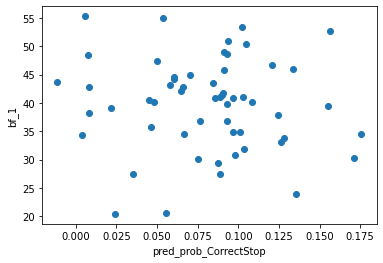

In [54]:
visualize_corr('pred_prob_CorrectStop','bf_1',full_dataset_cs)

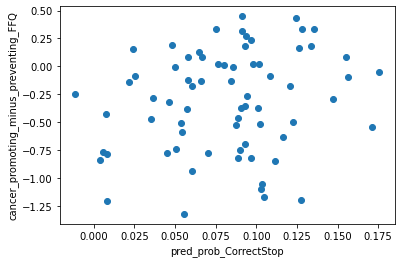

In [55]:
visualize_corr('pred_prob_CorrectStop','cancer_promoting_minus_preventing_FFQ',full_dataset_cs)

#### v3 mask

In [ ]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

In [ ]:
LinearSVC_correlation_masked = forced_choice_results_dict

In [ ]:
for k in forced_choice_results_dict.keys():
    v=forced_choice_results_dict[k]
    print(k)
    print_forced_choice_results(v,['pred_prob_CorrectStop'])

## Apply the main analysis, looping through masks

For the validation, we only want to run selected analyses:
1. Planning, bf_1
2. Executive function, bf_1
3. inhibition, FFQ
4. IFG pars triangularis, FFQ


In [33]:
validation_neural_correlate_for_mask = {
    'planning_association-test_z_FDR_0.01': ['bf_1'],
    'executive function_association-test_z_FDR_0.01': ['bf_1'],
    'inhibition_association-test_z_FDR_0.01': ['cancer_promoting_minus_preventing_FFQ'],
    'harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis': ['cancer_promoting_minus_preventing_FFQ']
}

### main set

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


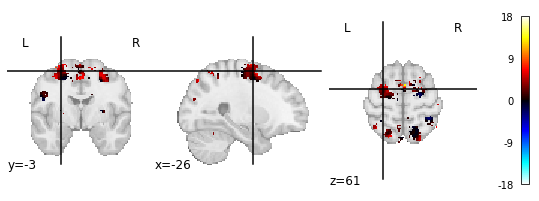

.................................................................................
['bf_1']
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)


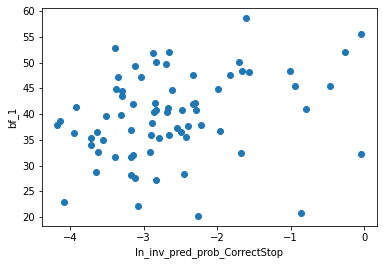

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


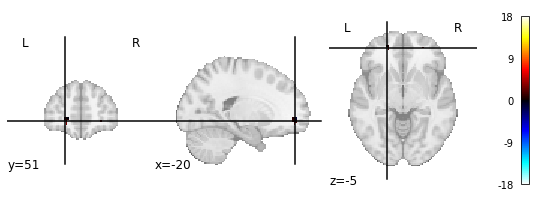

.................................................................................
['bf_1']
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)


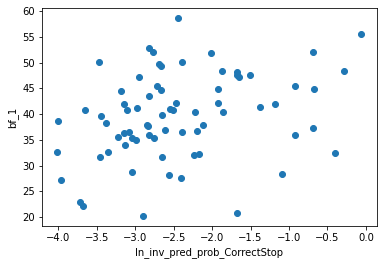

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


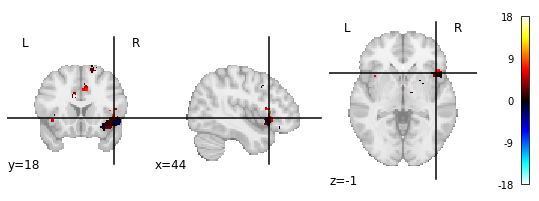

.................................................................................
['cancer_promoting_minus_preventing_FFQ']
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)


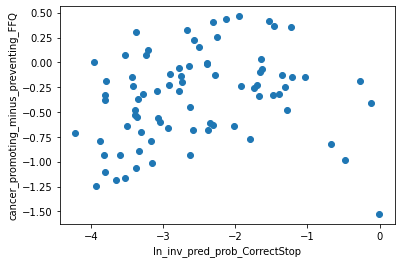

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


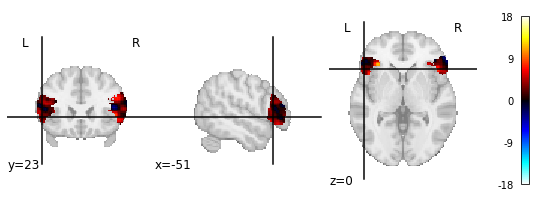

.................................................................................
['cancer_promoting_minus_preventing_FFQ']
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)


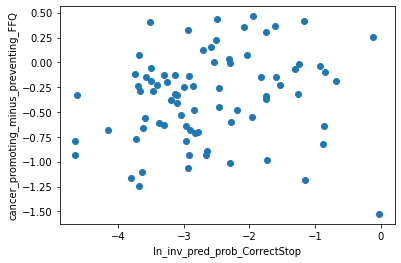

In [40]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath) and (mask_name in validation_neural_correlate_for_mask.keys()):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectStop'])

        outcome_measures_for_mask = validation_neural_correlate_for_mask[mask_name]
        print(outcome_measures_for_mask)
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(
            forced_choice_results,
            neural_measures = ['ln_inv_pred_prob_CorrectStop'],
            behavioral_measures = outcome_measures_for_mask
            )

### validation set

planning_association-test_z_FDR_0.01
2744.0365853658536


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


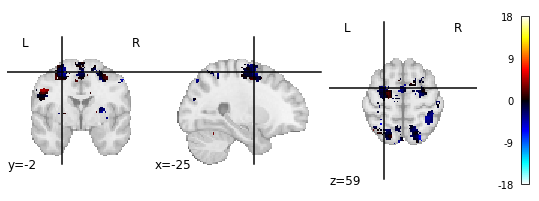

..................................................................................
['bf_1']
0.9512195121951219 0.9878048780487805
(0.9512195121951219, 0.9878048780487805)


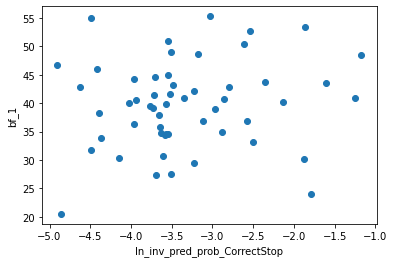

executive function_association-test_z_FDR_0.01
101.36585365853658


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


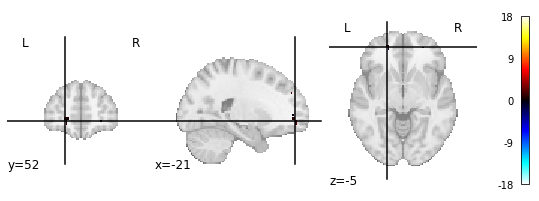

..................................................................................
['bf_1']
0.8902439024390244 0.975609756097561
(0.8902439024390244, 0.975609756097561)


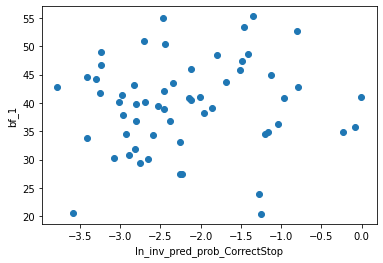

inhibition_association-test_z_FDR_0.01
658.5


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


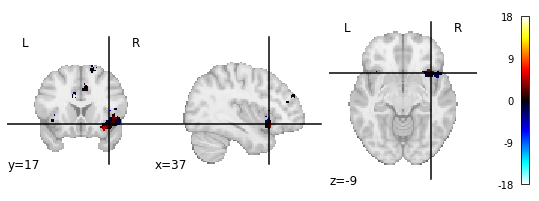

..................................................................................
['cancer_promoting_minus_preventing_FFQ']
0.9390243902439024 0.9634146341463414
(0.9390243902439024, 0.9634146341463414)


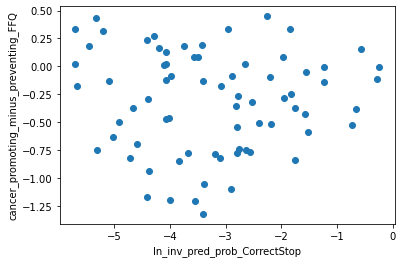

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2032.4268292682927


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


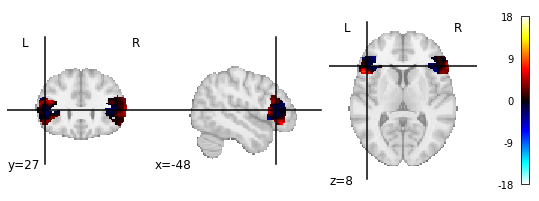

..................................................................................
['cancer_promoting_minus_preventing_FFQ']
0.9207317073170732 0.975609756097561
(0.9207317073170732, 0.975609756097561)


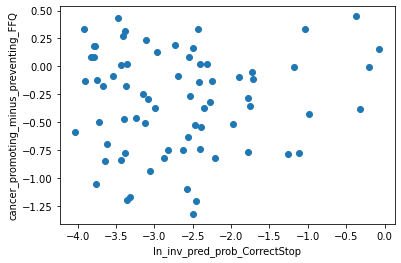

In [36]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath) and (mask_name in validation_neural_correlate_for_mask.keys()):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectStop'])

        outcome_measures_for_mask = validation_neural_correlate_for_mask[mask_name]
        print(outcome_measures_for_mask)
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(
            forced_choice_results,
            neural_measures = ['ln_inv_pred_prob_CorrectStop'],
            behavioral_measures = outcome_measures_for_mask
            )

In [37]:
SVC_proba_masked = forced_choice_results_dict

In [41]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

whole brain
129366.1768292683
..................................................................................0.9695121951219512 1.0
(0.9695121951219512, 1.0)


In [42]:
SVC_proba_wholebrain = forced_choice_results

## Contrast between CorrectStop and CorrectGo...

In [43]:
from sklearn.linear_model import Ridge

def do_Ridge(train_X,train_y,test_X,test_y):
    sklearn_reg = Ridge()

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_reg.fit(train_X, train_y)

    #get the _distance_ between predicted and actual
    #predict_y_prob = sklearn_reg.predict_proba(test_X)
    predict_y = sklearn_reg.predict(test_X)
    return(predict_y,sklearn_reg)


def do_regression(dataset,normalization=None,get_predict_and_prob=None):
    if get_predict_and_prob is None:
        get_predict_and_prob = do_Ridge
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
        
        predict_y, sklearn_reg = get_predict_and_prob(train_X,train_y,test_X,test_y)
        
        
        mae = abs(predict_y - test_y)

        accuracy_score = np.sum(mae)/len(mae)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'mae' : accuracy_score
            #'pred_y_forced_choice':forced_choice_predictions
        })
#         #add the class-wise probabilities
#         for cls in sklearn_clf.classes_:
#             sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, model_final =get_predict_and_prob(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'model':model_final})


In [44]:
def print_regression_results(forced_choice_results, neural_measures = ['mae']):
    sample_wise_results = forced_choice_results['sample_wise']
#    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(sample_wise_results,how='outer',left_on='subj_wave',right_on='chunks')
    print(full_dataset_cs.columns)
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
        full_dataset_cs,neural_measures = neural_measures,
        show_plot=False)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

In [ ]:
validation_neural_correlate_for_mask = {
    'planning_association-test_z_FDR_0.01':['cancer_promoting_minus_preventing_FFQ']
}

In [ ]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):

        target='SST_SSRT'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")


        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'])
        
mae_predictivity_masked = forced_choice_results_dict

In [ ]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl"
)

target='SST_SSRT'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(forced_choice_results,['mae'])

In [ ]:
mae_predictivity_wholebrain = forced_choice_results

## Test 2

In [ ]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [ ]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [ ]:
def pearsonr_not_na(x1,x2):
    not_na = (
        (np.isnan(x1)==False) & 
        (np.isnan(x2)==False)
    )

    return(pearsonr(x1[not_na],x2[not_na]))


In [ ]:
pearsonr_not_na(
    individual_differences.cancer_promoting_minus_preventing_FFQ,
    individual_differences.SST_SSRT
)



In [ ]:
pearsonr_not_na(
    individual_differences.cancer_promoting_minus_preventing_FFQ,
    individual_differences.TESQ_E_sum
)

In [ ]:
pearsonr_not_na(
    individual_differences.bf_1,
    individual_differences.SST_SSRT
)

In [ ]:
individual_differences

In [ ]:
pearsonr_not_na(
    individual_differences.bf_1,
    individual_differences.TESQ_E_sum
)

So actually, probably neural activity explains additional variance in a very straightforward way.

We found some relationships with FFQ. If these hold, it would be interesting to see support from them.

sooo...let's get a record of all the items from test 1 that we want to try running...

In [ ]:
def select_CS_trials(df):
    return(df[df['pred_y_forced_choice']=='CorrectStop'])

def select_CS_and_labels(df):
    return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)

In [ ]:
linearSVC_cor_wholebrain_CS_CS = label_cols(prepend="linearSVC_cor_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_wholebrain['sample_wise'])))
linearSVC_cor_planning_CS_CS = label_cols(prepend="linearSVC_cor_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_planning_CS_CS = label_cols(prepend="SVC_prob_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_exec_function_CS_CS = label_cols(prepend="SVC_prob_exec_function_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['executive function_association-test_z_FDR_0.01']['sample_wise'])))
SVC_inhib_CS_CS = label_cols(prepend="SVC_inhib_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['inhibition_association-test_z_FDR_0.01']['sample_wise'])))
SVC_IFG_PT_CS_CS = label_cols(prepend="SVC_IFG_PT_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis']['sample_wise'])))
SVC_wholebrain_CS_CS = label_cols(prepend="SVC_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_wholebrain['sample_wise'])))

In [ ]:
neural_all = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(
        linearSVC_cor_wholebrain_CS_CS,
        linearSVC_cor_planning_CS_CS),
        SVC_prob_planning_CS_CS),
        SVC_prob_exec_function_CS_CS),
        SVC_inhib_CS_CS),
        SVC_IFG_PT_CS_CS),
        SVC_wholebrain_CS_CS)

In [ ]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [ ]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_test1.csv")

In [ ]:
ml_data_folderpath

# PES

This section deals with post-error slowing. Unlike the GoNoGo comparison above, here, for simplicity, I present the validation only. You can see the orignal at `mvpa-all-ml-ns_on_nogo_go-v5-analysis_test1_2.ipynb`.

Also unlike the comparison above, I haven't selected the validation regressors below for display, although I have compiled them into a CSV file. You can open up the CSV output in R to measure the validation results.

In [39]:
from generic_utils import *
failure_mask_list=get_failure_masks(ml_data_folderpath)

In [29]:
from mvpa_sst_utils import *

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/mvpa_sst_utils.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [23]:
np.random.seed(1646100326)

In [24]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


whole brain
129855.93292682926
..................................................................................

In [26]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 
                        'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited',
                        'FFQ_v2_Mean_Weighted_Nutrient_Density']

In [34]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
#full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')

(0.725609756097561, 0.8536585365853658)


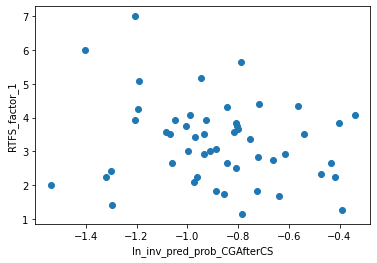

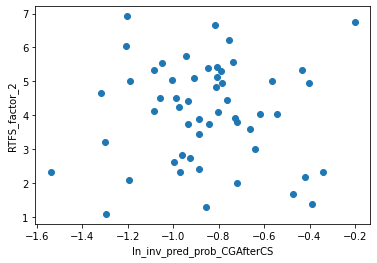

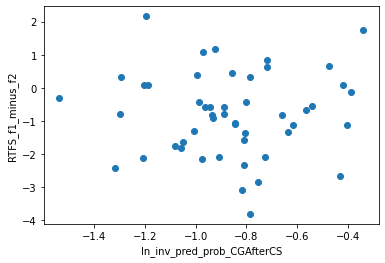

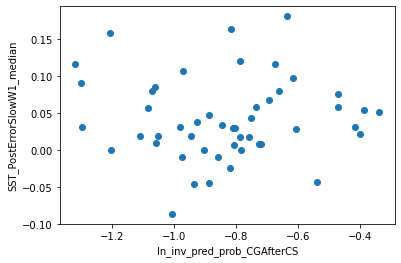

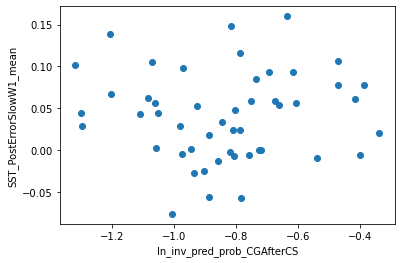

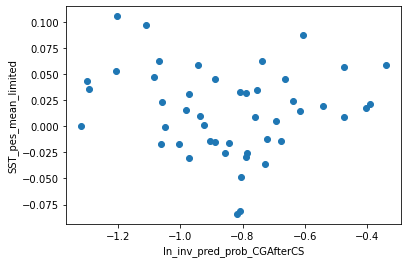

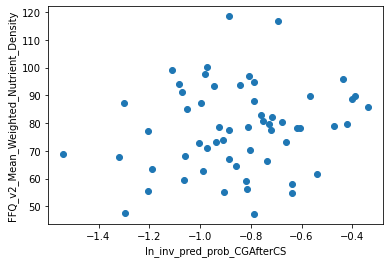

(0.725609756097561, 0.8536585365853658)


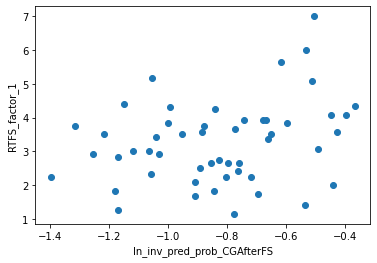

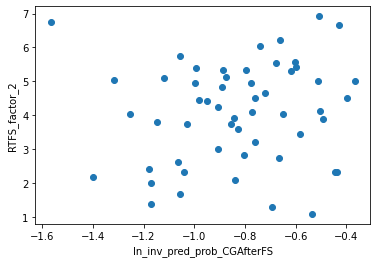

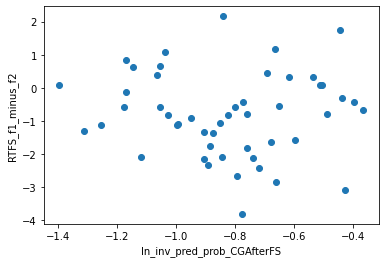

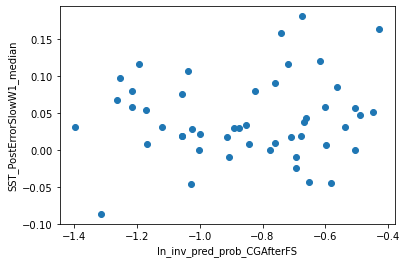

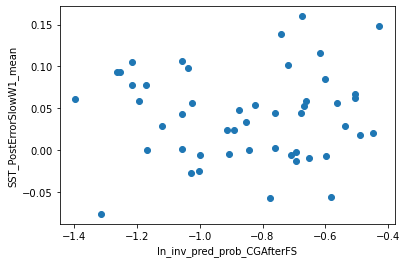

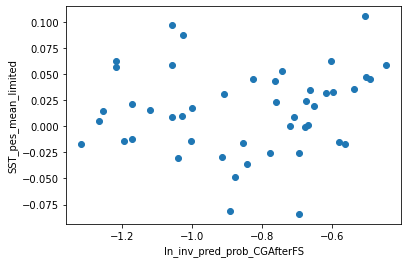

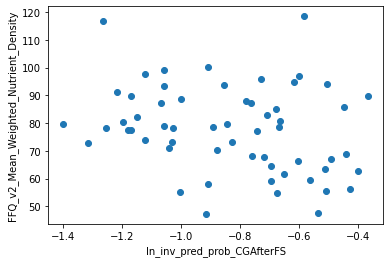

0.725609756097561 0.8536585365853658


In [35]:

forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])


print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    neural_measures = ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    neural_measures = ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

In [36]:
SVC_proba_wholebrain = forced_choice_results

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative affect_association-test_z_FDR_0.01.pkl
negative affect_association-test_z_FDR_0.01
1248.2317073170732


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


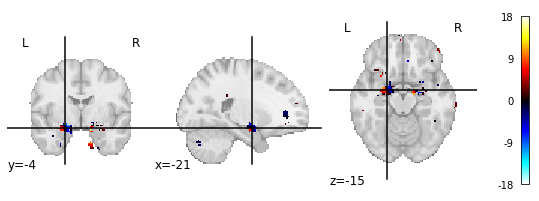

..................................................................................0.6158536585365854 0.6585365853658537
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_emotion regulation_association-test_z_FDR_0.01.pkl
emotion regulation_association-test_z_FDR_0.01
973.780487804878


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


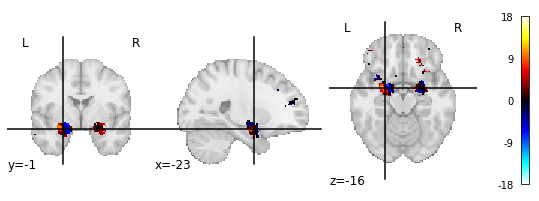

..................................................................................0.6158536585365854 0.3902439024390244
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Medial Cortex.pkl
harvardoxford-cortical_prob_Frontal Medial Cortex
1933.128048780488


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


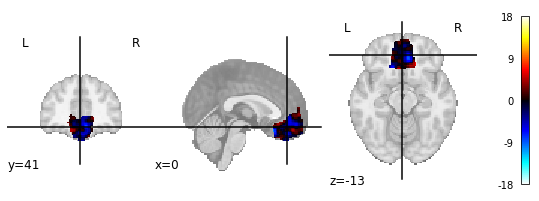

..................................................................................0.49390243902439024 0.43902439024390244
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative emotions_association-test_z_FDR_0.01.pkl
negative emotions_association-test_z_FDR_0.01
583.5243902439024


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


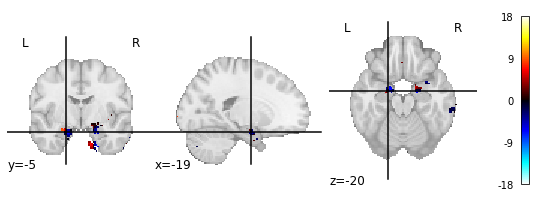

..................................................................................0.6341463414634146 0.7926829268292683
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_self referential_association-test_z_FDR_0.01.pkl
self referential_association-test_z_FDR_0.01
1938.0121951219512


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


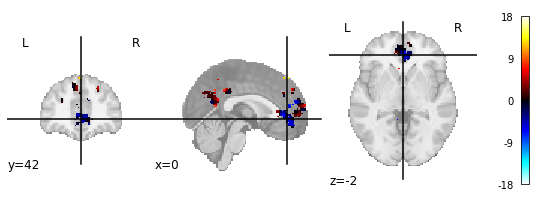

..................................................................................0.6219512195121951 0.3902439024390244
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl
harvardoxford-cortical_prob_Frontal Orbital Cortex
3013.4451219512193


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


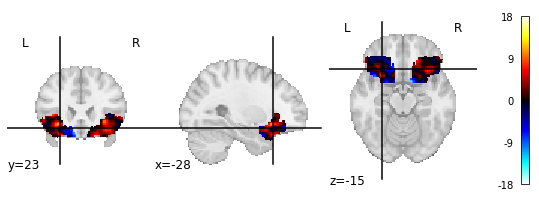

..................................................................................0.5670731707317073 0.3170731707317073
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.pkl
harvardoxford-cortical_prob_Cingulate Gyrus, anterior division
2913.560975609756


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


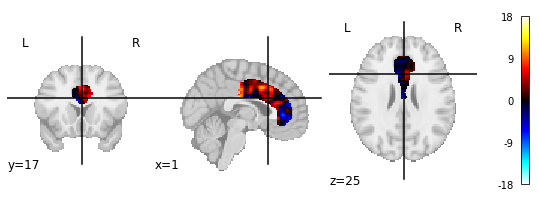

..................................................................................0.6219512195121951 0.7317073170731707


In [41]:
forced_choice_results_dict = {}
for m_i,m_r in failure_mask_list.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/val_set_incomplete_mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results

        
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterCS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingCorrectStop')
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterFS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingFailedStop')

In [42]:
pes_proba_masked = forced_choice_results_dict

In [43]:
def select_trials_by_type(df,trial_type):
    return(df[df['target_y']==trial_type])

def select_prob_col_with_label(df,prob_col):
    return(df.loc[:,['chunks',prob_col]])


# def select_CS_trials(df):
#     return(df[df['pred_y_forced_choice']=='CorrectStop'])

# def select_CS_and_labels(df):
#     return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)


In [44]:
pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGoFollowingCorrectStop,pred_prob_CorrectGoFollowingFailedStop,ln_inv_pred_prob_CGAfterCS,ln_inv_pred_prob_CGAfterFS
0,DEV004_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,0.544584,0.455416,-0.786545,-0.607732
1,DEV004_1,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.588203,0.411797,-0.887224,-0.530683
0,DEV007_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.638108,0.361892,-1.016409,-0.449248
1,DEV007_1,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,0.634978,0.365022,-1.007798,-0.454165
0,DEV008_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,0.523024,0.476976,-0.740289,-0.648128
...,...,...,...,...,...,...,...,...
1,DEV223_1,CorrectGoFollowingFailedStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.500000,0.500000,-0.693147,-0.693147
0,DEV224_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,0.544392,0.455608,-0.786122,-0.608086
1,DEV224_1,CorrectGoFollowingFailedStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.494773,0.505227,-0.682748,-0.703656
0,DEV225_1,CorrectGoFollowingCorrectStop,CorrectGoFollowingCorrectStop,CorrectGoFollowingFailedStop,0.481133,0.518867,-0.656107,-0.731612


In [76]:
CG_p_CS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingCorrectStop'),
    "pred_prob_CorrectGoFollowingCorrectStop"
),'CG_p_CS_wholebrain_')

CG_p_FS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_wholebrain_')

CG_p_FS_emotion_regulation = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['emotion regulation_association-test_z_FDR_0.01']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_emotion_regulation_')

CG_p_FS_Frontal_Orbital_Cortex = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_Frontal Orbital Cortex_')



In [77]:
CG_p_FS_Frontal_Orbital_Cortex

,chunks,CG_p_FS_Frontal Orbital Cortex_pred_prob_CorrectGoFollowingFailedStop
1,DEV004_1,0.411797
1,DEV007_1,0.365022
1,DEV008_1,0.462396
1,DEV031_1,0.475374
1,DEV033_1,0.514951
...,...,...
1,DEV219_1,0.382865
1,DEV222_1,0.571721
1,DEV223_1,0.500000
1,DEV224_1,0.505227


In [78]:
neural_all = pd.merge(pd.merge(pd.merge(
        CG_p_CS_wholebrain,
        CG_p_FS_wholebrain),
        CG_p_FS_emotion_regulation),
        CG_p_FS_Frontal_Orbital_Cortex,on='chunks')

In [79]:
", ".join(neural_all.columns)

'chunks, CG_p_CS_wholebrain_pred_prob_CorrectGoFollowingCorrectStop, CG_p_FS_wholebrain_pred_prob_CorrectGoFollowingFailedStop, CG_p_FS_emotion_regulation_pred_prob_CorrectGoFollowingFailedStop, CG_p_FS_Frontal Orbital Cortex_pred_prob_CorrectGoFollowingFailedStop'

In [80]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [81]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_pes_test1_validation.csv")